<a href="https://colab.research.google.com/github/sandJohnson/BlockChainStuff/blob/master/MaxEB_correlation_penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
PROPORTIONAL_SLASHING_MULTIPLIER_BELLATRIX = 3
EFFECTIVE_BALANCE_INCREMENT = 1_000_000_000
MIN_SLASHING_PENALTY_QUOTIENT_BELLATRIX = 2**5
MIN_SLASHING_PENALTY_QUOTIENT_ELECTRA = 2**12
EPOCHS_PER_SLASHINGS_VECTOR = 8_192
BASE_REWARD_FACTOR = 64
HYSTERESIS_QUOTIENT = 4
HYSTERESIS_DOWNWARD_MULTIPLIER = 1
HYSTERESIS_UPWARD_MULTIPLIER = 5
EFFECTIVE_BALANCE_LIMIT = 2048 * EFFECTIVE_BALANCE_INCREMENT


def integer_squareroot(n: int) -> int:
    """
    Return the largest integer ``x`` such that ``x**2 <= n``.
    """
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x

def decrease_balance(balance, amount):
    return 0 if balance < amount else balance - amount


def get_base_reward(tb, eb):
    increments = eb // EFFECTIVE_BALANCE_INCREMENT
    return increments * EFFECTIVE_BALANCE_INCREMENT * BASE_REWARD_FACTOR // integer_squareroot(tb)


def compute_updated_effective_balance(eb, balance):
    HYSTERESIS_INCREMENT = EFFECTIVE_BALANCE_INCREMENT // HYSTERESIS_QUOTIENT
    DOWNWARD_THRESHOLD = HYSTERESIS_INCREMENT * HYSTERESIS_DOWNWARD_MULTIPLIER
    UPWARD_THRESHOLD = HYSTERESIS_INCREMENT * HYSTERESIS_UPWARD_MULTIPLIER
    if (
        balance + DOWNWARD_THRESHOLD < eb
        or eb + UPWARD_THRESHOLD < balance
    ):
        return min(balance - balance % EFFECTIVE_BALANCE_INCREMENT, EFFECTIVE_BALANCE_LIMIT)
    else:
        return eb


def compute_balance_after_attestation_penalties(tb, eb, balance, epochs):
    balance = eb
    updated_eb = eb
    dbg = []
    for _ in range (epochs):
      penalty = get_base_reward(tb, updated_eb)
      balance = decrease_balance(balance, penalty)
      updated_eb = compute_updated_effective_balance(updated_eb, balance)

    return balance, updated_eb


def compute_correlation_penalty(tb, sb, eb):
    increment = EFFECTIVE_BALANCE_INCREMENT  # Factored out from penalty numerator to avoid uint64 overflow
    adjusted_total_slashing_balance = min(sb * PROPORTIONAL_SLASHING_MULTIPLIER_BELLATRIX, tb)
    penalty_numerator = eb // increment * adjusted_total_slashing_balance
    return penalty_numerator // tb * increment


def compute_correlation_penalty_electra(tb, sb, eb):
    increment = EFFECTIVE_BALANCE_INCREMENT  # Factored out from total balance to avoid uint64 overflow
    adjusted_total_slashing_balance = min(sb * PROPORTIONAL_SLASHING_MULTIPLIER_BELLATRIX, tb)
    penalty_per_eb_increment = adjusted_total_slashing_balance // (tb // increment)
    eb_increments = eb // increment
    return penalty_per_eb_increment * eb_increments


def compute_initial_penalty(eb):
    return eb // MIN_SLASHING_PENALTY_QUOTIENT_BELLATRIX


def compute_initial_penalty_electra(eb):
    return eb // MIN_SLASHING_PENALTY_QUOTIENT_ELECTRA


def compute_total_slashing_penalty(tb, sb, eb) -> tuple[int, int, int, int]:
    balance = eb
    # apply initial penalty
    ip = compute_initial_penalty(eb)
    balance = decrease_balance(balance, ip)
    updated_eb = compute_updated_effective_balance(eb, balance)
    # apply attestation penalties
    post_balance, updated_eb = compute_balance_after_attestation_penalties(tb, updated_eb, balance, EPOCHS_PER_SLASHINGS_VECTOR // 2)
    ap = balance - post_balance
    balance = post_balance
    # apply correlation penalties
    cp = compute_correlation_penalty(tb, sb, updated_eb)
    balance = decrease_balance(balance, cp)

    return eb - balance, ip, ap, cp


def compute_total_slashing_penalty_electra(tb, sb, eb) -> tuple[int, int, int, int]:
    balance = eb
    # apply initial penalty
    ip = compute_initial_penalty_electra(eb)
    balance = decrease_balance(balance, ip)
    updated_eb = compute_updated_effective_balance(eb, balance)
    # apply attestation penalties
    post_balance, updated_eb = compute_balance_after_attestation_penalties(tb, updated_eb, balance, EPOCHS_PER_SLASHINGS_VECTOR // 2)
    ap = balance - post_balance
    balance = post_balance
    # apply correlation penalties
    cp = compute_correlation_penalty_electra(tb, sb, updated_eb)
    balance = decrease_balance(balance, cp)

    return eb - balance, ip, ap, cp

In [ ]:
TV = 2**20
TB = 32 * TV * EFFECTIVE_BALANCE_INCREMENT

slashed_vals = [i for i in range(0, 10000, 100)] + [i for i in range(0, TV * 2 // 3, 10000)]
slashed_balances = [32 * EFFECTIVE_BALANCE_INCREMENT * vals for vals in slashed_vals]

bellatrix_32eth = []
bellatrix_2048eth = []
electra_32eth = []
electra_2048eth = []

for sb in slashed_balances:
  bellatrix_32eth.append(compute_total_slashing_penalty(TB, sb, 32 * EFFECTIVE_BALANCE_INCREMENT))
  bellatrix_2048eth.append(compute_total_slashing_penalty(TB, sb, 2048 * EFFECTIVE_BALANCE_INCREMENT))
  electra_32eth.append(compute_total_slashing_penalty_electra(TB, sb, 32 * EFFECTIVE_BALANCE_INCREMENT))
  electra_2048eth.append(compute_total_slashing_penalty_electra(TB, sb, 2048 * EFFECTIVE_BALANCE_INCREMENT))


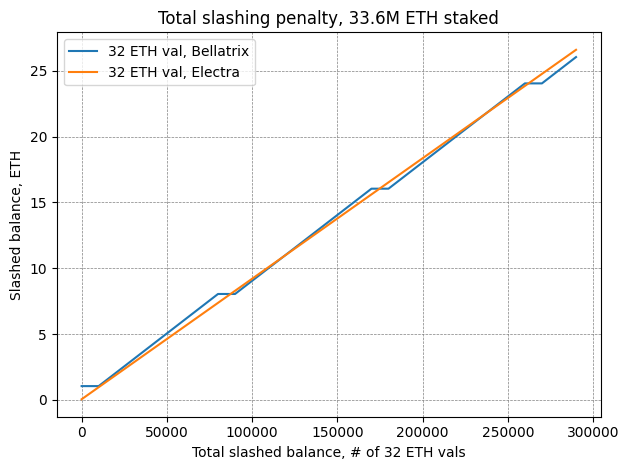

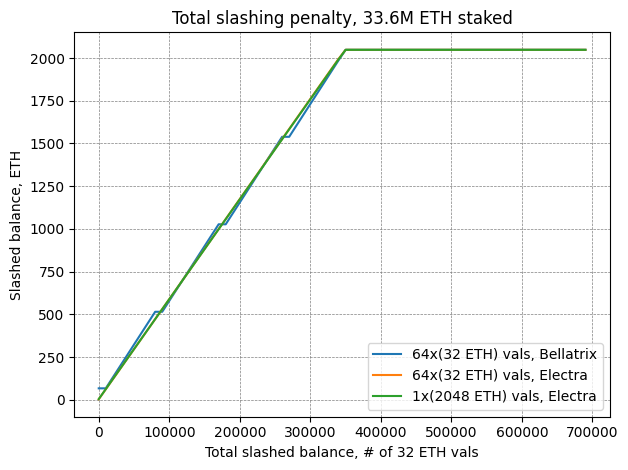

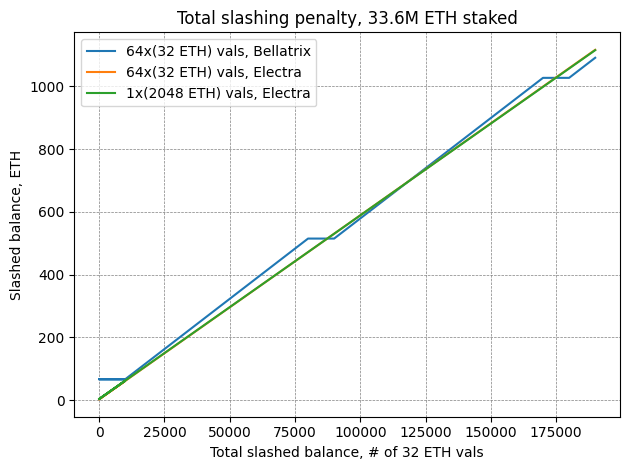

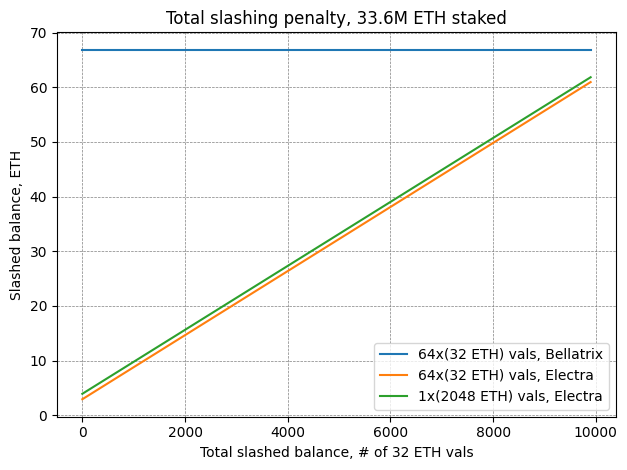

In [ ]:
import matplotlib.pyplot as plt

bellatrix_64x32eth = []
bellatrix_1x32eth = []
electra_64x32eth = []
electra_1x32eth = []
electra_1x2048eth = []

for i in range(len(slashed_vals)):
  bellatrix_1x32eth.append(bellatrix_32eth[i][0] / EFFECTIVE_BALANCE_INCREMENT)
  bellatrix_64x32eth.append(64 * bellatrix_32eth[i][0] / EFFECTIVE_BALANCE_INCREMENT)

  electra_1x32eth.append(electra_32eth[i][0] / EFFECTIVE_BALANCE_INCREMENT)
  electra_64x32eth.append(64 * electra_32eth[i][0] / EFFECTIVE_BALANCE_INCREMENT)
  electra_1x2048eth.append(electra_2048eth[i][0] / EFFECTIVE_BALANCE_INCREMENT)

# 1 x 32eth

plt.plot(slashed_vals[:130], bellatrix_1x32eth[:130], label="32 ETH val, Bellatrix")
plt.plot(slashed_vals[:130], electra_1x32eth[:130], label="32 ETH val, Electra")
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.ylabel('Slashed balance, ETH')
plt.title('Total slashing penalty, 33.6M ETH staked')
plt.legend()
plt.tight_layout()
plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
plt.show()

# 64 x 32eth, 1 x 2048eth
plt.plot(slashed_vals, bellatrix_64x32eth, label="64x(32 ETH) vals, Bellatrix")
plt.plot(slashed_vals, electra_64x32eth, label="64x(32 ETH) vals, Electra")
plt.plot(slashed_vals, electra_1x2048eth, label="1x(2048 ETH) vals, Electra")
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.ylabel('Slashed balance, ETH')
plt.title('Total slashing penalty, 33.6M ETH staked')
plt.legend()
plt.tight_layout()
plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Zoomed in charts
plt.plot(slashed_vals[:120], bellatrix_64x32eth[:120], label="64x(32 ETH) vals, Bellatrix")
plt.plot(slashed_vals[:120], electra_64x32eth[:120], label="64x(32 ETH) vals, Electra")
plt.plot(slashed_vals[:120], electra_1x2048eth[:120], label="1x(2048 ETH) vals, Electra")
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.ylabel('Slashed balance, ETH')
plt.title('Total slashing penalty, 33.6M ETH staked')
plt.legend()
plt.tight_layout()
plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
plt.show()

plt.plot(slashed_vals[:100], bellatrix_64x32eth[:100], label="64x(32 ETH) vals, Bellatrix")
plt.plot(slashed_vals[:100], electra_64x32eth[:100], label="64x(32 ETH) vals, Electra")
plt.plot(slashed_vals[:100], electra_1x2048eth[:100], label="1x(2048 ETH) vals, Electra")
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.ylabel('Slashed balance, ETH')
plt.title('Total slashing penalty, 33.6M ETH staked')
plt.legend()
plt.tight_layout()
plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
plt.show()

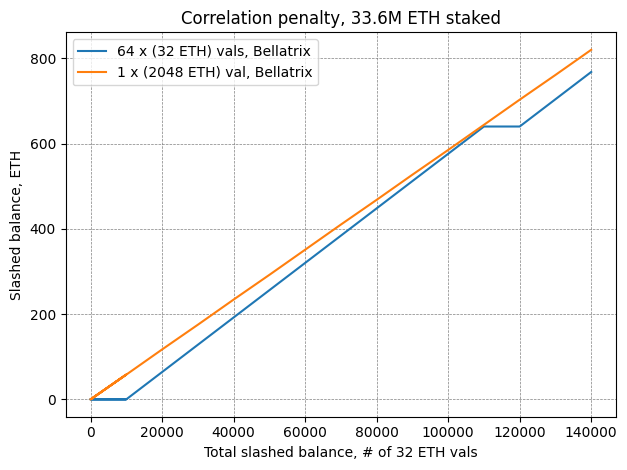

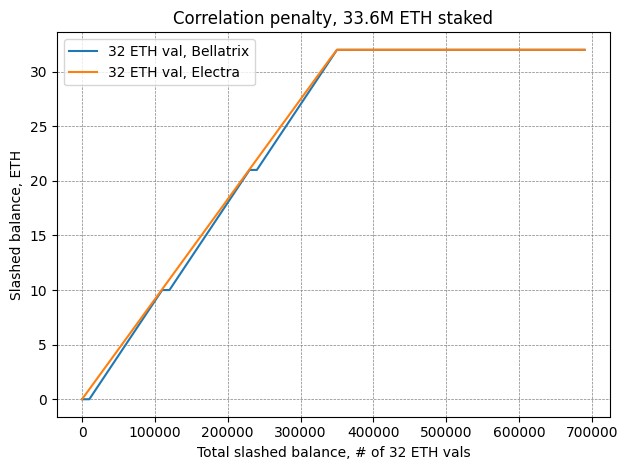

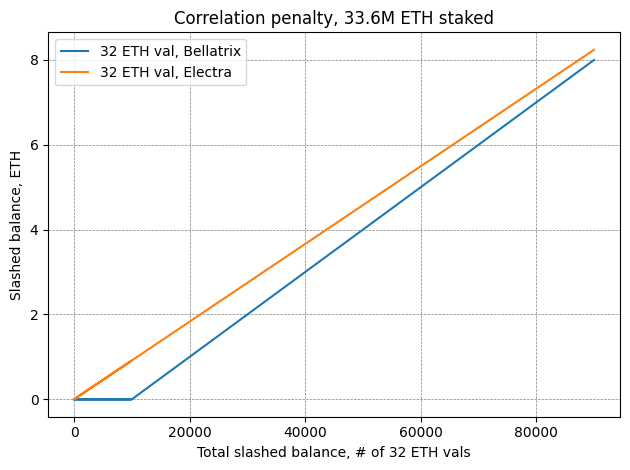

In [ ]:
import matplotlib.pyplot as plt

bellatrix_1x32eth = []
bellatrix_64x32eth = []
bellatrix_1x2048eth = []
electra_1x32eth = []

for sb in slashed_balances:
  bellatrix_1x32eth.append(compute_correlation_penalty(TB, sb, 32 * EFFECTIVE_BALANCE_INCREMENT) / EFFECTIVE_BALANCE_INCREMENT)
  bellatrix_64x32eth.append(64 * compute_correlation_penalty(TB, sb, 32 * EFFECTIVE_BALANCE_INCREMENT) / EFFECTIVE_BALANCE_INCREMENT)
  bellatrix_1x2048eth.append(compute_correlation_penalty(TB, sb, 2048 * EFFECTIVE_BALANCE_INCREMENT) / EFFECTIVE_BALANCE_INCREMENT)

  electra_1x32eth.append(compute_correlation_penalty_electra(TB, sb, 32 * EFFECTIVE_BALANCE_INCREMENT) / EFFECTIVE_BALANCE_INCREMENT)
  electra_1x2048eth.append(compute_correlation_penalty_electra(TB, sb, 2048 * EFFECTIVE_BALANCE_INCREMENT) / EFFECTIVE_BALANCE_INCREMENT)

S = 115
plt.plot(slashed_vals[:S], bellatrix_64x32eth[:S], label="64 x (32 ETH) vals, Bellatrix")
plt.plot(slashed_vals[:S], bellatrix_1x2048eth[:S], label="1 x (2048 ETH) val, Bellatrix")
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.ylabel('Slashed balance, ETH')
plt.title('Correlation penalty, 33.6M ETH staked')
plt.legend()
plt.tight_layout()
plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
plt.show()

plt.plot(slashed_vals, bellatrix_1x32eth, label="32 ETH val, Bellatrix")
plt.plot(slashed_vals, electra_1x32eth, label="32 ETH val, Electra")
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.ylabel('Slashed balance, ETH')
plt.title('Correlation penalty, 33.6M ETH staked')
plt.legend()
plt.tight_layout()
plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Zoomed in chart
S = 110
plt.plot(slashed_vals[:S], bellatrix_1x32eth[:S], label="32 ETH val, Bellatrix")
plt.plot(slashed_vals[:S], electra_1x32eth[:S], label="32 ETH val, Electra")
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.ylabel('Slashed balance, ETH')
plt.title('Correlation penalty, 33.6M ETH staked')
plt.legend()
plt.tight_layout()
plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
plt.show()


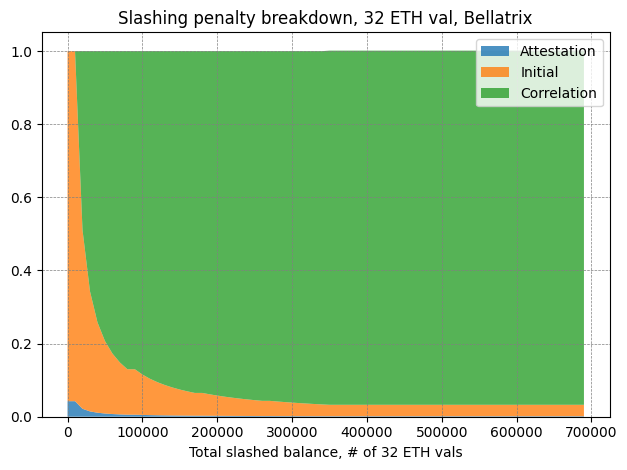

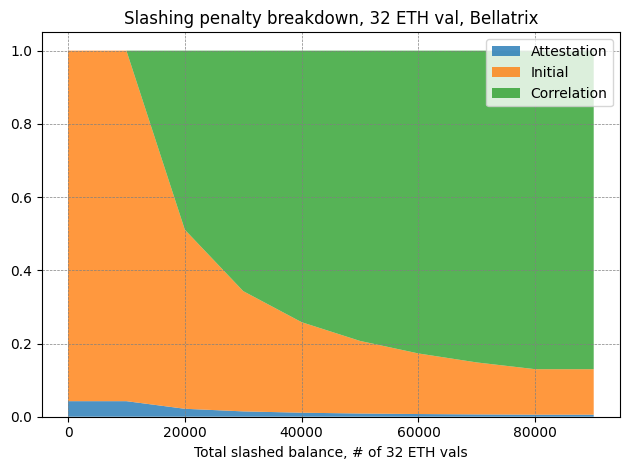

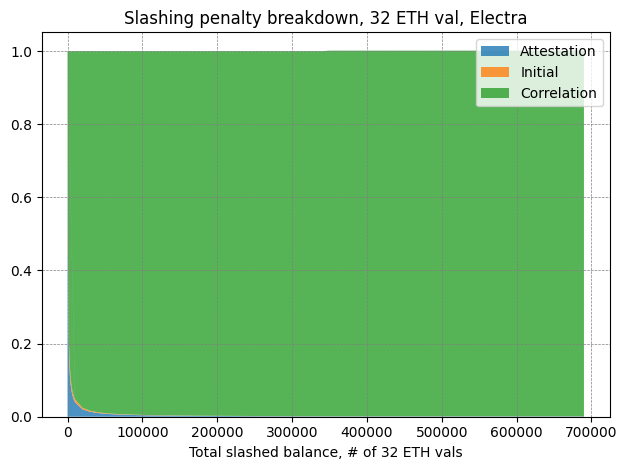

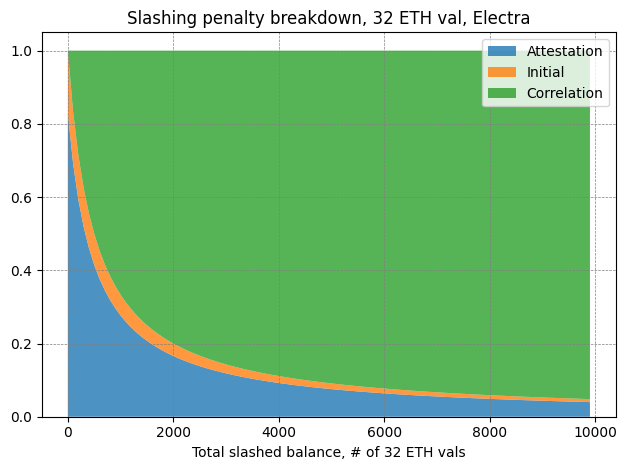

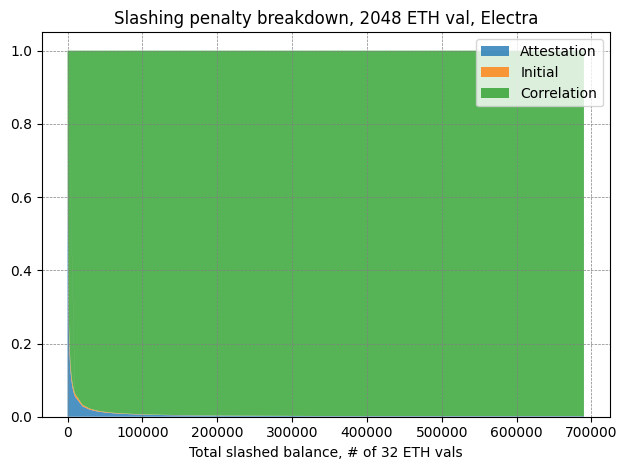

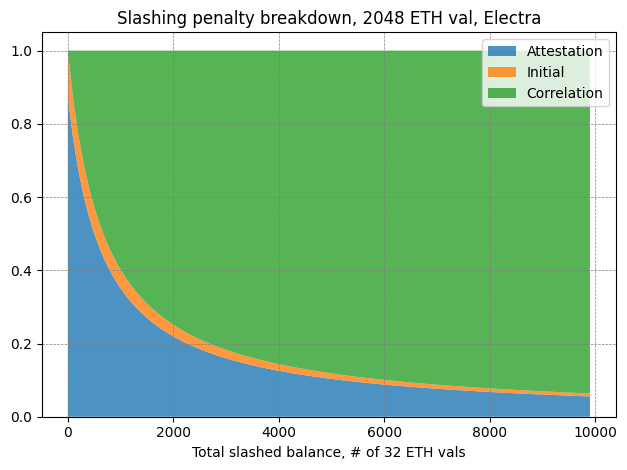

In [ ]:
import matplotlib.pyplot as plt

bellatrix_32eth_ips = []
bellatrix_32eth_aps = []
bellatrix_32eth_cps = []
electra_32eth_ips = []
electra_32eth_aps = []
electra_32eth_cps = []
electra_2048eth_ips = []
electra_2048eth_aps = []
electra_2048eth_cps = []

for i in range(len(slashed_vals)):
  bellatrix_32eth_ips.append(bellatrix_32eth[i][1] / bellatrix_32eth[i][0])
  bellatrix_32eth_aps.append(bellatrix_32eth[i][2] / bellatrix_32eth[i][0])
  bellatrix_32eth_cps.append(bellatrix_32eth[i][3] / bellatrix_32eth[i][0])
  electra_32eth_ips.append(electra_32eth[i][1] / electra_32eth[i][0])
  electra_32eth_aps.append(electra_32eth[i][2] / electra_32eth[i][0])
  electra_32eth_cps.append(electra_32eth[i][3] / electra_32eth[i][0])
  electra_2048eth_ips.append(electra_2048eth[i][1] / electra_2048eth[i][0])
  electra_2048eth_aps.append(electra_2048eth[i][2] / electra_2048eth[i][0])
  electra_2048eth_cps.append(electra_2048eth[i][3] / electra_2048eth[i][0])

# Bellatrix, 32 ETH
plt.stackplot(slashed_vals, bellatrix_32eth_aps, bellatrix_32eth_ips, bellatrix_32eth_cps,
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 32 ETH val, Bellatrix')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

plt.stackplot(slashed_vals[:110], bellatrix_32eth_aps[:110], bellatrix_32eth_ips[:110], bellatrix_32eth_cps[:110],
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 32 ETH val, Bellatrix')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Electra, 32 ETH
plt.stackplot(slashed_vals, electra_32eth_aps, electra_32eth_ips, electra_32eth_cps,
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 32 ETH val, Electra')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

plt.stackplot(slashed_vals[:100], electra_32eth_aps[:100], electra_32eth_ips[:100], electra_32eth_cps[:100],
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 32 ETH val, Electra')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Electra, 2048 ETH
plt.stackplot(slashed_vals, electra_2048eth_aps, electra_2048eth_ips, electra_2048eth_cps,
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 2048 ETH val, Electra')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

plt.stackplot(slashed_vals[:100], electra_2048eth_aps[:100], electra_2048eth_ips[:100], electra_2048eth_cps[:100],
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 2048 ETH val, Electra')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

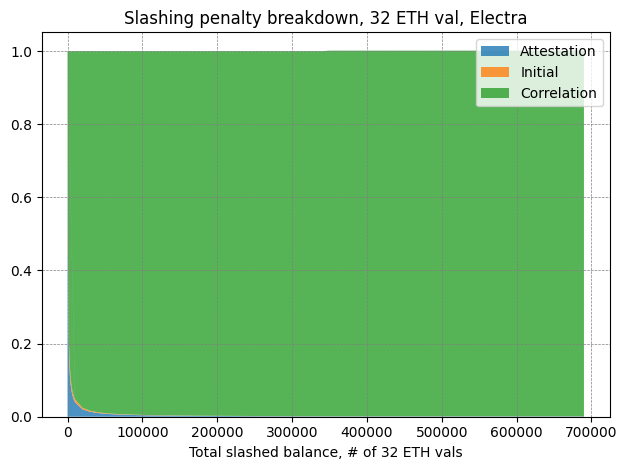

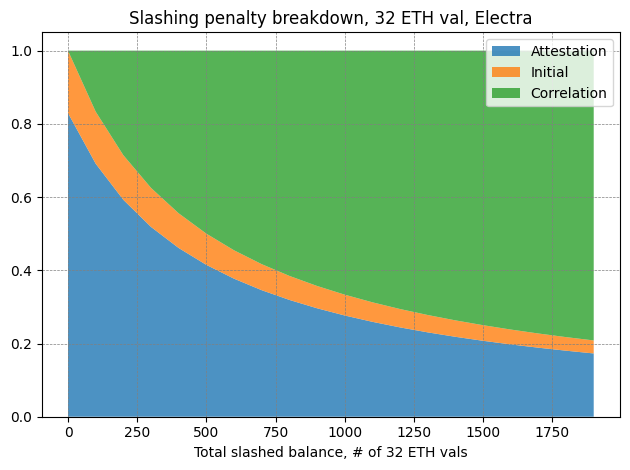

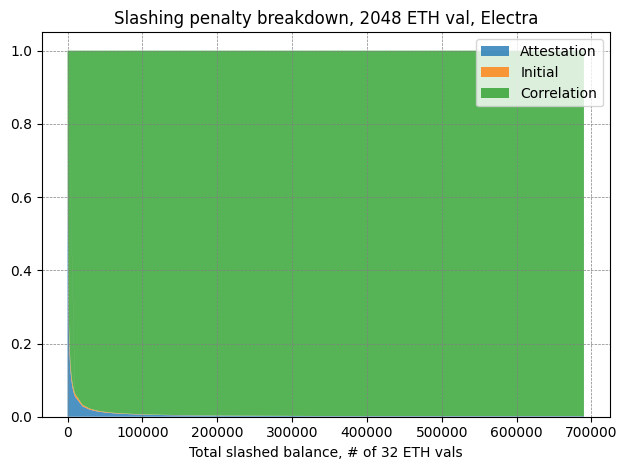

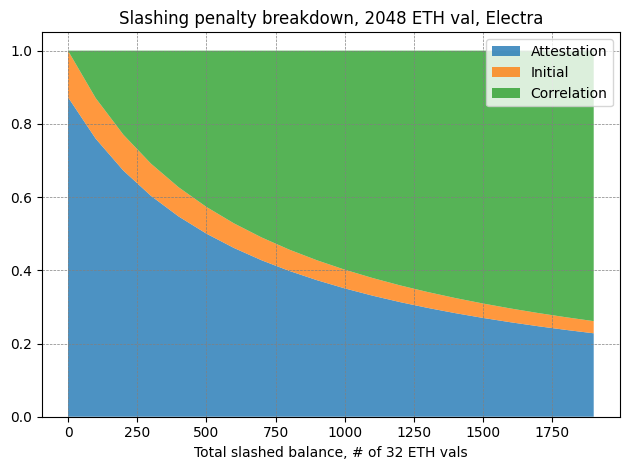

In [ ]:
# Electra, 32 ETH
plt.stackplot(slashed_vals, electra_32eth_aps, electra_32eth_ips, electra_32eth_cps,
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 32 ETH val, Electra')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

plt.stackplot(slashed_vals[:20], electra_32eth_aps[:20], electra_32eth_ips[:20], electra_32eth_cps[:20],
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 32 ETH val, Electra')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Electra, 2048 ETH
plt.stackplot(slashed_vals, electra_2048eth_aps, electra_2048eth_ips, electra_2048eth_cps,
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 2048 ETH val, Electra')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

plt.stackplot(slashed_vals[:20], electra_2048eth_aps[:20], electra_2048eth_ips[:20], electra_2048eth_cps[:20],
              labels=['Attestation', 'Initial', 'Correlation'], alpha=0.8,
              )
plt.xlabel('Total slashed balance, # of 32 ETH vals')
plt.title('Slashing penalty breakdown, 2048 ETH val, Electra')
plt.legend()
plt.tight_layout()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()